In [16]:
import earthaccess
import xarray as xr
import pandas as pd
import requests
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

In [17]:
auth = earthaccess.login(persist=True)

In [18]:
tspan = ("2024-03-01", "2024-03-31")
# bbox = (113.338953078, -43.6345972634, 153.569469029, -10.6681857235)
# BIG BOY: 
bbox = (123.084, -29.566, 138.024, -17.050)

In [19]:
results_land = earthaccess.search_data(
    short_name="PACE_OCI_L3M_SFREFL",
    temporal=tspan,
    granule_name="*.MO.*0p1deg*",  # Daily, /8-day or monthly: Day, 8D or MO | Resolution: 0p1deg or 0.4km
)

In [20]:
paths = earthaccess.open(results_land)
paths

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240301_20240331.L3m.MO.SFREFL.V3_0.rhos.0p1deg.nc>]

In [21]:
dataset_land = xr.open_dataset(paths[0])

In [22]:
min_lon, max_lat, max_lon, min_lat = bbox
ds_australia = dataset_land.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

In [23]:
def read_spectral_data(component_name):    
   # url = "https://pds-geosciences.wustl.edu/mro/mro-m-crism-4-typespec-v1/mrocr_8001/data/crism_typespec_hematite.tab"
    url = f"https://pds-geosciences.wustl.edu/mro/mro-m-crism-4-typespec-v1/mrocr_8001/data/crism_typespec_{component_name}.tab"

    response = requests.get(url)
    response.raise_for_status()  
    
    data = pd.read_csv(StringIO(response.text), delimiter=',')
    data = np.array(data)
    
    data_dict = {}
    data_dict['wavelength'] =data[:,0] * 1000 # nm
    data_dict['spectral_reflectance'] =data[:,1] # DIMENSIONLESS
    
    return data_dict

def assign_wvl_signature(component_name, ds_inst):
    spectral_component = read_spectral_data(component_name)
    wvl_component = spectral_component['wavelength']
    refl_component = spectral_component['spectral_reflectance']
    wvl_inst = ds_inst['wavelength'].values

    result = {
        'instrument_wavelength': [],
        'component_wavelength': [],
        'spectral_signature': []
    }

    for wvl in wvl_inst:
        idx = np.argmin(np.abs(wvl_component - wvl))
        result['instrument_wavelength'].append(float(wvl))
        result['component_wavelength'].append(float(wvl_component[idx]))
        result['spectral_signature'].append(float(refl_component[idx]))

    return result

spectral_hematite = read_spectral_data('hematite') # Hematite
spectral_mg_olivine = read_spectral_data('mg_olivine') # Mg-Olivine
spectral_fe_olivine = read_spectral_data('fe_olivine') # Fe-Olivine
spectral_plagioclase = read_spectral_data('plagioclase') #  Plagioclase
spectral_lcp = read_spectral_data('lcp') # Low-Ca Pyroxene
spectral_hcp = read_spectral_data('hcp') # High-Ca Pyroxene

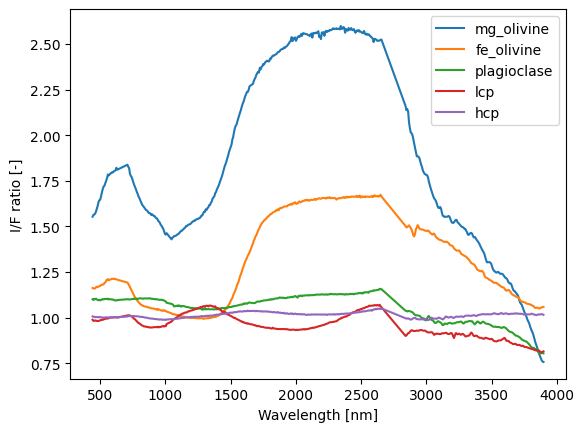

In [24]:
plt.figure()
# plt.plot(spectral_hematite['wavelength'], spectral_hematite['spectral_reflectance'], label = 'hematite')
plt.plot(spectral_mg_olivine['wavelength'], spectral_mg_olivine['spectral_reflectance'], label = 'mg_olivine')
plt.plot(spectral_fe_olivine['wavelength'], spectral_fe_olivine['spectral_reflectance'], label = 'fe_olivine')
plt.plot(spectral_plagioclase['wavelength'], spectral_plagioclase['spectral_reflectance'], label = 'plagioclase')
plt.plot(spectral_lcp['wavelength'], spectral_lcp['spectral_reflectance'], label = 'lcp')
plt.plot(spectral_hcp['wavelength'], spectral_hcp['spectral_reflectance'], label = 'hcp')
plt.xlabel('Wavelength [nm]')
plt.ylabel('I/F ratio [-]')
plt.legend()
plt.show()

In [25]:
wvl_hematite = spectral_hematite['wavelength']
# wvl_hematite

In [26]:
refl_hematite = spectral_hematite['spectral_reflectance']
# refl_hematite

In [27]:
ds_test_hematite = assign_wvl_signature('hematite', ds_australia)
# ds_test_hematite

In [28]:
# (np.array(ds_test_hematite['instrument_wavelength'])-np.array(ds_test_hematite['component_wavelength']))

In [29]:
# dataset_land.to_dataarray()
ds_australia

<xarray.Dataset> Size: 9MB
Dimensions:     (lat: 126, lon: 149, wavelength: 122, rgb: 3, eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 976B 346.0 351.0 ... 2.131e+03 2.258e+03
  * lat         (lat) float32 504B -17.05 -17.15 -17.25 ... -29.35 -29.45 -29.55
  * lon         (lon) float32 596B 123.2 123.3 123.4 123.5 ... 137.8 137.9 138.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    rhos        (lat, lon, wavelength) float32 9MB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/62)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.SFRE...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/SFREFL/3.0
    data_bins:                         5259270
    data_minimum:                      -0.050000012
    data_maximum:                      1.0

In [30]:
# aust_dict = dict()
# aust_dict['lon'] = ds_australia['lon'].values
# aust_dict['lat'] = ds_australia['lat'].values
# aust_dict['reflectance'] = ds_australia['rhos'].values

In [31]:
# np.shape(np.array(aust_dict['reflectance'])[:,:,0])

In [39]:
def matched_filter(image, spectral_name):
    spectral = assign_wvl_signature(spectral_name, image)
    image = image.sel(wavelength=spectral['instrument_wavelength'])
    import time
    reflectance = image['rhos'].values  # shape: (lat, lon, bands)
    lat = image['lat'].values
    lon = image['lon'].values
    h, w, b = reflectance.shape

    img = reflectance.transpose(2, 0, 1).reshape(b, -1)

    valid_mask = ~np.any(np.isnan(img), axis=0)
    img_valid = img[:, valid_mask]
    
    start_time = time.time()
    img_mean = np.nanmean(img_valid, axis=1)
    img_cov = np.cov(img_valid, rowvar=True)
    W_inv = np.linalg.inv(img_cov)

    target = np.array(spectral['spectral_signature'])

    alpha_flat = np.zeros(h * w)

    for idx in range(h * w):
        if not valid_mask[idx]:
            alpha_flat[idx] = 0
            continue

        pixel = img[:, idx]
        l_mean = pixel - img_mean
        a_num = l_mean.T @ W_inv @ target
        a_den = target.T @ W_inv @ target
        a = a_num / a_den if a_den != 0 else 0
        alpha_flat[idx] = max(a, 0)

    alpha = alpha_flat.reshape(h, w)

    return {
        'lat': lat,
        'lon': lon,
        'reflectance': reflectance,
        'alpha': alpha
    }


In [40]:
aust_hematite = matched_filter(ds_australia, 'hematite')

In [34]:
ds_aust_hematite = xr.Dataset(
    data_vars={
        'reflectance': (('lat', 'lon', 'band'), aust_hematite['reflectance']),
        'alpha': (('lat', 'lon'), aust_hematite['alpha']),
    },
    coords={
        'lat': aust_hematite['lat'],
        'lon': aust_hematite['lon'],
    }
)


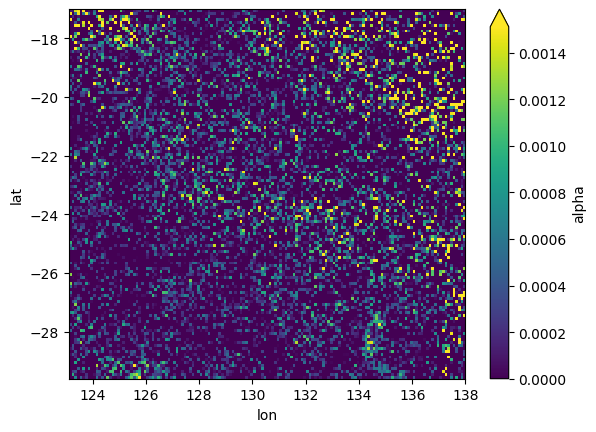

In [35]:
# ds_aust_hematite = ds_aust_hematite.to_dataarray()
ds_aust_hematite['alpha'].plot.imshow(robust=True)

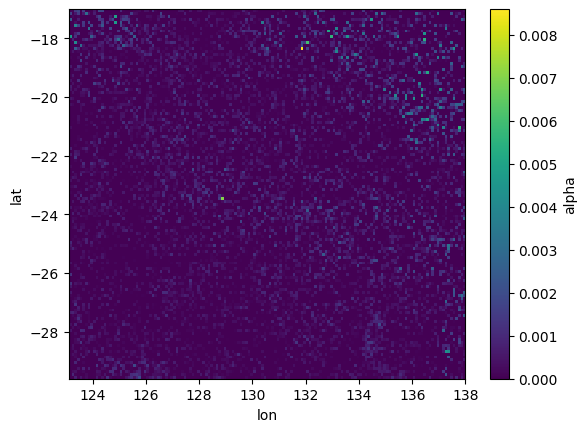

In [36]:
ds_aust_hematite['alpha'].plot.imshow()

In [37]:
# # log.info("Writing output to GeoTIFF...")
# labels_2d = ds_aust_hematite['alpha'].sortby("lat", ascending=False)
# labels_2d.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
# labels_2d.rio.write_crs("EPSG:4326", inplace=True)
# labels_2d.rio.to_raster("hematite_mf.tif")
# # log.info("GeoTIFF saved as hematite_alpha.tif")

In [38]:
def plot_mf(image, spectra_name, robust=False):
    aust_hematite = matched_filter(ds_australia, 'hematite')
    component_mf = matched_filter(ds_australia, spectra_name)

    ds_component = xr.Dataset(
        data_vars={
            'reflectance': (('lat', 'lon', 'band'), component_mf['reflectance']),
            'alpha': (('lat', 'lon'), component_mf['alpha']),
        },
        coords={
            'lat': component_mf['lat'],
            'lon': component_mf['lon'],
        }
    )

    if robust:
        ds_component['alpha'].plot.imshow(robust=True)
    else:       
        ds_component['alpha'].plot.imshow()


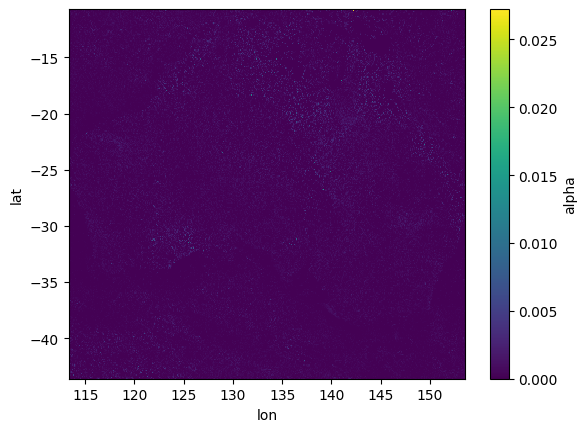

In [37]:
plot_mf(ds_australia, 'hematite', robust=False)

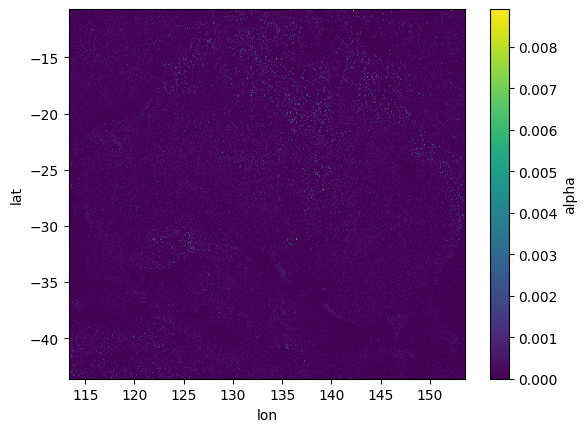

In [38]:
plot_mf(ds_australia, 'mg_olivine', robust=False)

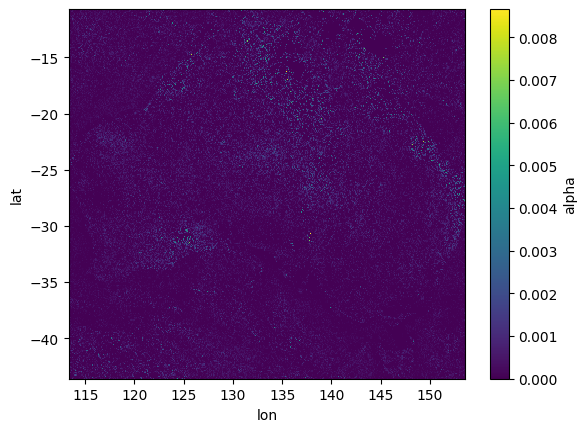

In [39]:
plot_mf(ds_australia, 'fe_olivine', robust=False)

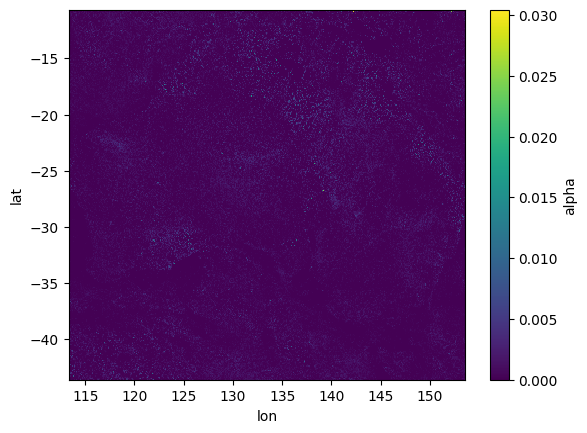

In [40]:
plot_mf(ds_australia, 'plagioclase', robust=False)

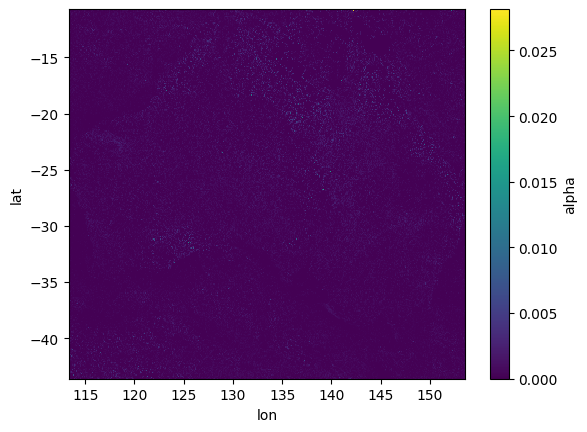

In [41]:
plot_mf(ds_australia, 'lcp', robust=False)

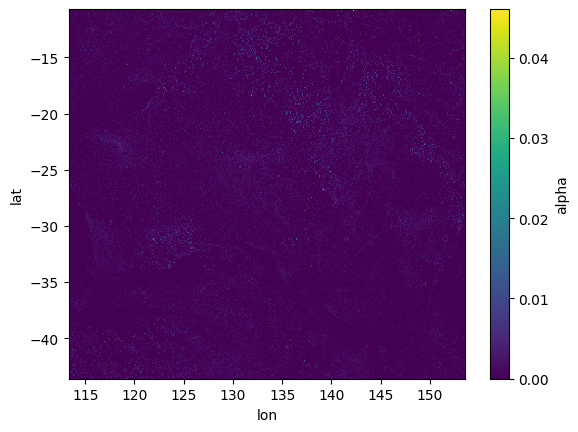

In [42]:
plot_mf(ds_australia, 'hcp', robust=False)

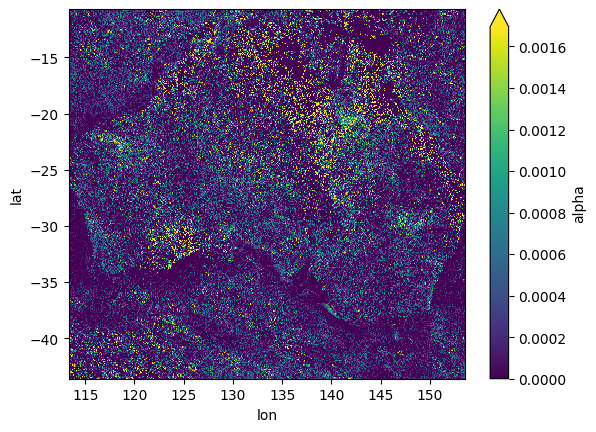

In [44]:
plot_mf(ds_australia, 'hematite', robust=True)

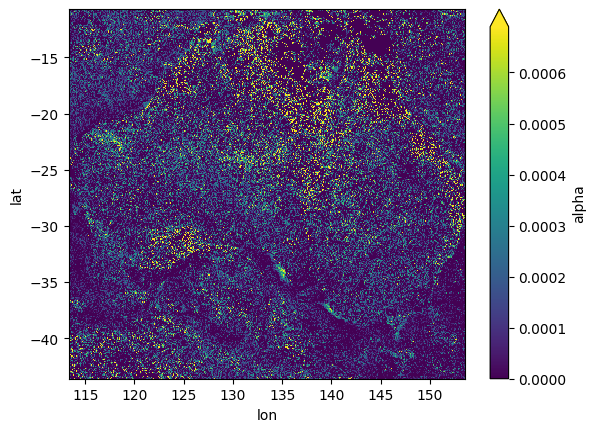

In [45]:
plot_mf(ds_australia, 'mg_olivine', robust=True)

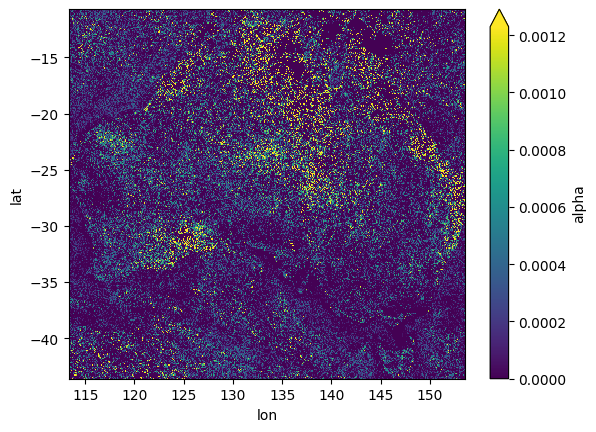

In [46]:
plot_mf(ds_australia, 'fe_olivine', robust=True)

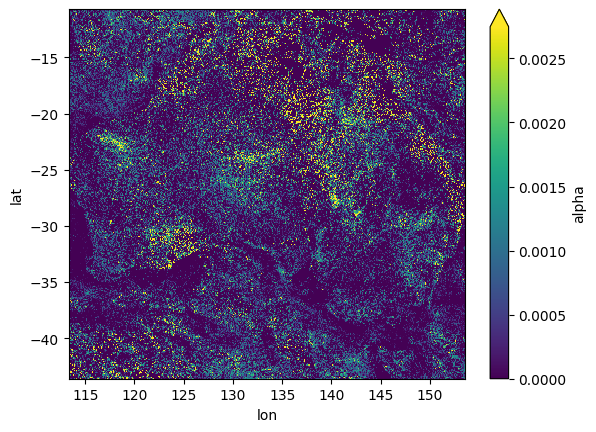

In [47]:
plot_mf(ds_australia, 'plagioclase', robust=True)

In [ ]:
plot_mf(ds_australia, 'lcp', robust=True)

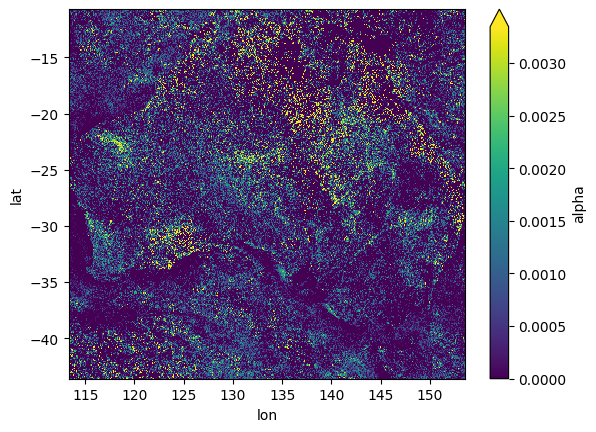

In [49]:
plot_mf(ds_australia, 'hcp', robust=True)

In [ ]:
# spectral_hematite = read_spectral_data('hematite') # Hematite
# spectral_mg_olivine = read_spectral_data('mg_olivine') # Mg-Olivine
# spectral_fe_olivine = read_spectral_data('fe_olivine') # Fe-Olivine
# spectral_plagioclase = read_spectral_data('plagioclase') #  Plagioclase
# spectral_lcp = read_spectral_data('lcp') # Low-Ca Pyroxene
# spectral_hcp = read_spectral_data('hcp') # High-Ca Pyroxene